# Test Time Augmention

After training an ensemble or any other bayesian neural network on a dataset, we create an augmented version of the dataset to test on. This augmented dataset allows us probe our model's confidence in predictions. In this example we are working with the MNIST dataset, and apply rotations as well as noise at test time. By plotting the change in logits and probabilities over a range of rotations we can obeserve our model's uncertainty when viewing new data that is not similar to the training set.

## Rotation Augmentation

##### Dataset

In [1]:
import torch
import copy
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from experiments.nns.bdl import SelectMNISTDataset


# Define the path to directory containing MNIST
mnist_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("uncertainty.ipynb")), "..","..","..","..","..","..","..", "/usr/data1/vision/data/"))


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training dataset
train_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=10, transform=transform)

## Creating rotated dataset

In [2]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from experiments.nns.bdl import CustomMNISTDataset

# Choose what number we would like to test
selected_numbers = [1]

rotation_angles = []
for i in range(12):
    rotation_angles.append(i*5.5)
def get_rotated_mnist_dataset(degrees):
    rotate_transform = transforms.Compose([
            transforms.RandomRotation(degrees=(degrees, degrees), fill=(0,)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    rotated_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=rotate_transform)
    rotated_loader = DataLoader(rotated_dataset, batch_size=512, shuffle=False)
    return rotated_dataset, rotated_loader
rotated_datasets = []
rotated_loaders = []

for angle in rotation_angles:
    rotated_dataset, rotated_loader = get_rotated_mnist_dataset(angle)
    rotated_datasets.append(rotated_dataset)
    rotated_loaders.append(rotated_loader)


test_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

## Training

In [3]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble
from experiments.nns.lenet.lenet import LeNet


# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs = 50
n = 25
lr = 0.01

ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        LeNet,
        num_devices=2,
        num_ensembles=n,
        cache_size=25
    )

100%|██████████| 50/50 [00:17<00:00,  2.84it/s, loss=tensor(0.2697)] 


In [4]:
import push.bayes.swag

pretrain_epochs = 25
swag_epochs = 25
swag = push.bayes.swag.train_mswag(
    train_loader,
    torch.nn.CrossEntropyLoss(),
    pretrain_epochs,
    swag_epochs,
    LeNet,
    num_devices = 2,
    num_models = n,
    lr = lr,
)

100%|██████████| 25/25 [00:34<00:00,  1.38s/it, loss=tensor(0.4718)]


In [5]:
import push.bayes.stein_vgd

svgd = push.bayes.stein_vgd.train_svgd(
    train_loader,                       # Dataloader
    torch.nn.CrossEntropyLoss(),        # Loss Fn
    epochs,                             # Epochs
    10,                                  # Number of particles
    LeNet,                              # NN
    lengthscale = 0.25,                  # Lengthscale
    lr = 3e-1,                          # Learning Rate
    num_devices = 2,                    # Number of devices
)

100%|██████████| 50/50 [01:50<00:00,  2.21s/it, loss=tensor(2.3215)]


## Inference

In [6]:
ensemble_outputs = []
for loader in rotated_loaders:
    ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

swag_outputs = []
for loader in rotated_loaders:
    swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

svgd_outputs = []
for loader in rotated_loaders:
    svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

def get_mode(output, mode):
    return output[mode]

## Helper functions for output and plots

# Gaussian Noise

In [7]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from experiments.nns.bdl import CustomMNISTDataset
from experiments.nns.bdl import AddGaussianNoise
from experiments.nns.bdl import AddImpulseNoise
from experiments.nns.bdl import AddDefocusBlur


# Choose what number we would like to test
selected_numbers = [1]
variances = [0.1 ,0.2, 0.4, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
probs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12]
scales = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
radi = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

def get_noisy_mnist_dataset(selected_numbers, noise):
    noisy_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    noise
    ])
    noisy_dataset = SelectMNISTDataset(root=mnist_directory, numbers=selected_numbers, num_entries_per_digit=1, train=False, transform=noisy_transform)
    noisy_loader = DataLoader(noisy_dataset, batch_size=1, shuffle=False)
    return noisy_dataset, noisy_loader

gaussian_datasets = []
gaussian_loaders = []
for variance in variances:
    gaussian_dataset, gaussian_loader = get_noisy_mnist_dataset(selected_numbers, AddGaussianNoise(0., variance))
    gaussian_datasets.append(gaussian_dataset)
    gaussian_loaders.append(gaussian_loader)

impulse_datasets = []
impulse_loaders = []
for prob in probs:
    impulse_dataset, impulse_loader = get_noisy_mnist_dataset(selected_numbers, AddImpulseNoise(prob))
    impulse_datasets.append(impulse_dataset)
    impulse_loaders.append(impulse_loader)

defocus_datasets = []
defocus_loaders = []
for radius in radi:
    defocus_dataset, defocus_loader = get_noisy_mnist_dataset(selected_numbers, AddDefocusBlur(radius))
    defocus_datasets.append(defocus_dataset)
    defocus_loaders.append(defocus_loader)

In [8]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

gaussian_ensemble_outputs = []
gaussian_swag_outputs = []
gaussian_svgd_outputs = []
for loader in gaussian_loaders:
    gaussian_ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    gaussian_swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    gaussian_svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

impulse_ensemble_outputs = []
impulse_swag_outputs = []
impulse_svgd_outputs = []
for loader in impulse_loaders:
    impulse_ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    impulse_swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    impulse_svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

defocus_ensemble_outputs = []
defocus_swag_outputs = []
defocus_svgd_outputs = []
for loader in defocus_loaders:
    defocus_ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    defocus_swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    defocus_svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))


def get_mode(output, mode):
    return output[mode]



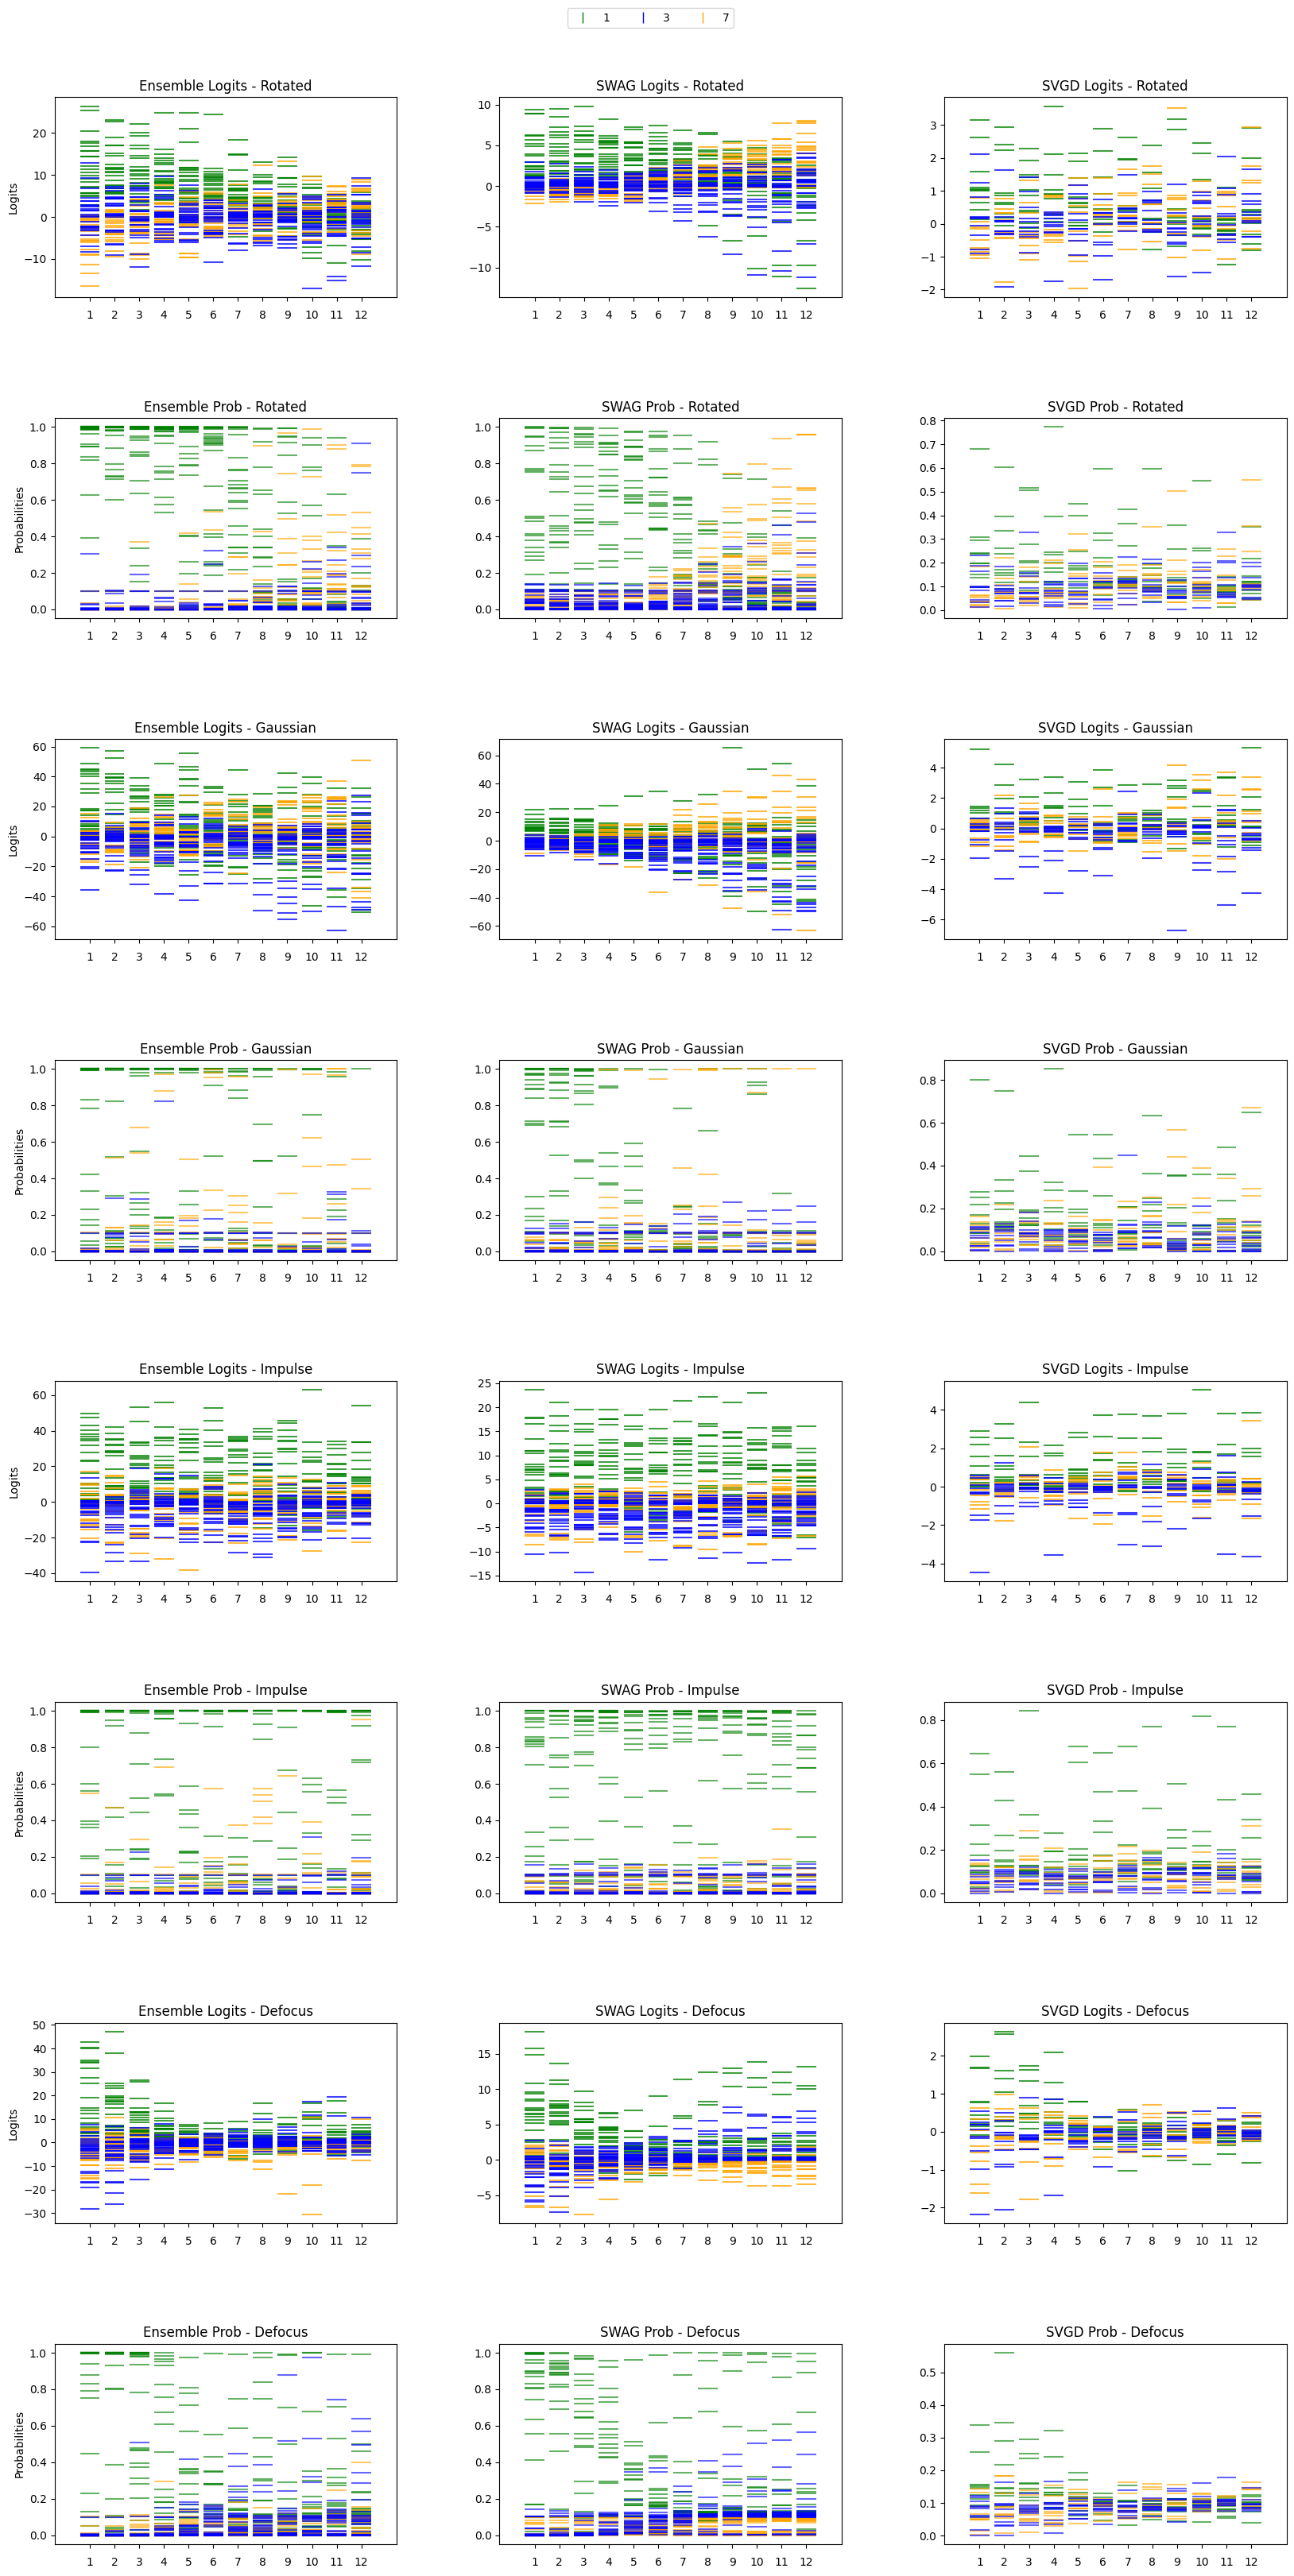

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_imgs(loaders, idx_image_to_display=0):
    imgs = []
    for loader in loaders:
        for images, _ in loader:
            imgs.append(images[idx_image_to_display])
            break
    return imgs

def offset_image(coord, ax, low_img, low_index, zoom, img):
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, low_img), xybox=(0.0, low_index), frameon=False, boxcoords="offset points")
    ax.add_artist(ab)

def align_images_on_x_axis(ax):
    # Find the transformed position of the lower limit of the y-axis
    inv = ax.transData.inverted()
    # Set to a fixed offset from the bottom of the axes
    _, y_data_coord = inv.transform((0, ax.figure.bbox.ymin))
    y_offset = y_data_coord - 0.3  # Adjust this offset as needed

    # Update the y-coordinates for images in this axis
    for ab in [child for child in ax.get_children() if isinstance(child, AnnotationBbox)]:
        ab.xybox = (0.0, y_offset)

def plot_data(ax, outputs, title, loaders, idx_image_to_display=0, stat_type="logits"):
    color_map = {"logits": ["green", "orange", "blue"], "prob": ["green", "orange", "blue"]}
    alpha_map = {"logits": 0.75, "prob": 0.6}
    index = np.arange(len(outputs))
    imgs = get_imgs(loaders, idx_image_to_display)
    zoom = 0.4

    for i, output in enumerate(outputs):
        data = get_mode(output, stat_type)[:, :, [1, 3, 7]][idx_image_to_display]
        for j, val in enumerate(data.T):
            ax.eventplot(val, orientation="vertical", lineoffsets=i, linelengths=0.8, colors=color_map[stat_type][j], alpha=alpha_map[stat_type])

    setup_axis(ax, index, title, stat_type)
    # annotate_images(ax, index, imgs, zoom)
    align_images_on_x_axis(ax)

def setup_axis(ax, index, title, stat_type):
    ax.set_xticks(index)
    ax.set_xticklabels(index + 1)
    ax.tick_params(axis="x", which="major", pad=8)
    ax.set_ylabel("Logits" if stat_type == "logits" else "Probabilities")
    ax.set_title(title, fontsize=12)

def annotate_images(ax, index, imgs, zoom):
    low_img, _ = ax.get_ylim()
    for i, img in enumerate(imgs):
        offset_image(i, ax, low_img, low_img - 5, zoom, img)

def get_mode(output, mode):
    return output[mode]

# Define the datasets and loaders
# Ensure outputs and loaders are defined: ensemble_outputs, swag_outputs, svgd_outputs, etc.

method_names = ['Ensemble', 'SWAG', 'SVGD']
noise_types = ['Rotated', 'Gaussian', 'Impulse', 'Defocus']
outputs_dict = {
    'Rotated': (ensemble_outputs, swag_outputs, svgd_outputs, rotated_loaders),
    'Gaussian': (gaussian_ensemble_outputs, gaussian_swag_outputs, gaussian_svgd_outputs, gaussian_loaders),
    'Impulse': (impulse_ensemble_outputs, impulse_swag_outputs, impulse_svgd_outputs, impulse_loaders),
    'Defocus': (defocus_ensemble_outputs, defocus_swag_outputs, defocus_svgd_outputs, defocus_loaders)
}


# Plotting code
fig_width, fig_height = 20, 40  # Increase figure height to provide more space
fig, axes = plt.subplots(nrows=2*len(noise_types), ncols=len(method_names), figsize=(fig_width, fig_height))

for row_idx, noise in enumerate(noise_types):
    for col_idx, method in enumerate(method_names):
        outputs, loaders = outputs_dict[noise][col_idx], outputs_dict[noise][-1]
        # Plot logits
        ax_logits = axes[2*row_idx, col_idx]
        plot_data(ax_logits, outputs, f"{method} Logits - {noise}", loaders, stat_type='logits')
        # Plot probabilities
        ax_prob = axes[2*row_idx + 1, col_idx]
        plot_data(ax_prob, outputs, f"{method} Prob - {noise}", loaders, stat_type='prob')
        # Hide y-labels for all but the first column
        if col_idx > 0:
            ax_logits.set_ylabel('')
            ax_prob.set_ylabel('')

# Adjust subplot parameters to fit everything
plt.subplots_adjust(hspace=0.6, wspace=0.3)

import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='green', marker='|', linestyle='None', markersize=10, label='1'),
    mlines.Line2D([], [], color='blue', marker='|', linestyle='None', markersize=10, label='3'),
    mlines.Line2D([], [], color='orange', marker='|', linestyle='None', markersize=10, label='7'),
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.9), ncol=3)

# Save the plot to a file to prevent display issues in Jupyter Notebook
# plt.savefig('/augmentation_plot.png', dpi=300, bbox_inches='tight')

plt.show()




[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.